# Comparing Networks

In this notebook, we want to compare different network to each other.
We will start of with...

- Untrained Model
- Trained Model
- Trained Model (Exact Unlearning)*$^1$

All these model should serve as comparison point for approximate MU Algorithms, which we want to try out

*$^1$ Exact Unlearning: refers to an complete retraining of the Model, without the samples which we want to unlearn.

Notiz:
- Entscheiden darüber was zu gelöscht und was zu nicht gelöscht gehört, ist das 'e' am Ende des Ordner Namen. Um sicherzugehen, dass es einheitlich mit der Downloadfunktion des Skripts ist, sollte die `if` Klausel in `mlp_dataclass.py` line __376__ should be adjusted by removing/adding the `not`

- Dauer für alle Opparationen in diesen Notebook: Start - ca. 9:15 Uhr | Ende - ca. ...


In [ ]:
import os
import sys

# Add the parent directory to sys.path
sys.path.append(os.path.join('..', 'src'))

import torch
import copy
from PIL import Image
import numpy as np

from mlp_dataclass import MNIST_CostumDataset, TwoLayerPerceptron, ConvNet
from training import main, train_n_models
from helper import load_models_dict

USED_DATASET = "mnist"
# OUT OF: ["mnist", "cmnist", "fashion_mnist"]

ALLREADY_TRAINED = True
all_data = MNIST_CostumDataset(
    sample_mode="all",
    train= True,
    test = True,
    dataset_name = USED_DATASET,
    download=True,
)

unlearned_data = MNIST_CostumDataset(
    sample_mode="only_erased",
    train= False,
    test = True,
    classes=["7"],
    dataset_name = USED_DATASET,
    download=True,
)

c:\Users\morit\miniconda3\envs\bach.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
unlearned_data.length

889

In [3]:
def prepare_sample(path:str):
    """preps sample to pass to model, transforms to tensor, reshape to 784, shaping it as batch"""
    sample = Image.open(path).convert("L")
    sample = torch.Tensor(np.array(sample)).reshape(784)
    
    return sample.unsqueeze(0)

def show_sample(sample:torch.Tensor):
    """Converts the sample to a numpy array and reshapes it to a 28x28 image"""
    sample = sample.reshape(28, 28)
    sample = sample.numpy()
    sample = Image.fromarray(sample)
    return sample

____

### Untrained Model

We want to include an untrained model as a pour reference point.

Later, we will compare the differently trained (and untrained) models on different metrics. We are thinking, that the **untrained model should always be the furthest neighbor** and see if thats true. Also out of pur curiosity, how do the models compare according to the found metrics to the untrained model.

It could be interesting to see, if the unlearned models tend to be more similar to the "Exact MU Model" or to the "Untrained Model"

The "Trained Model"´s and "Exact Model"´s starting point is the "Untrained Model". That means all models can be traced back to it.

In [4]:
from training import save_model

if not ALLREADY_TRAINED:
    untrained_model = TwoLayerPerceptron() if USED_DATASET in ["mnist", "fashion_mnist"] else ConvNet()
    # save it first
    save_model(untrained_model, name="showcase_untrained", path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained", logs=False)

    untrained_ms = {v: TwoLayerPerceptron() for v in range(30)} if USED_DATASET in ["mnist", "fashion_mnist"] else {v: ConvNet() for v in range(30)}

    for i, model in untrained_ms.items():
        save_model(model=model, name=i, path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}ensemble")
else:
    if USED_DATASET in ["mnist", "fashion_mnist"]:
        untrained_showcase_all= TwoLayerPerceptron()
    if USED_DATASET in ["cmnist"]:
        untrained_showcase_all = ConvNet()
    name = str(untrained_showcase_all)
    untrained_showcase_all.load_state_dict(
        torch.load(
            f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}{name}_showcase_untrained",
            weights_only=True
            )
        )
    untrained_ms = load_models_dict(f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}ensemble")

___

### Trained Model

This model will be the starting point for all MU algorithms. The more it is important that it does not change throughout the experiments, otherwise we need to run everything again.

Notes Regarding the Dataloader: We included Up-/Downsampling. There is a counter in the Dataset class, which controls, which class is next to provide a sample. From the available pool a sample will be chosen at random.

Reason: The amount of available samples should not influence the performance of the model on certain classes.

Regarding the samples for the class "7": There are more samples of sevens without a middle line than ones with.

Ratio: 
- 6268 (train: 5385, test: 883)
- 1025 (train: 880,  test: 145)

Should there be concerns regarding that the bigger part of the sevens (without middle line) will be unlearning?

In [5]:
# Train a single model first
if not ALLREADY_TRAINED:
    trained_showcase_all = main(
        new_name="trained_showcase",
        model=None,
        sampling_mode="all",
        balanced=True,
        dataset_name="fashion_mnist",
        include_val=True,
        logs=True,
    )
else:
    if USED_DATASET in ["mnist", "fashion_mnist"]:
        trained_showcase_all= TwoLayerPerceptron()
    if USED_DATASET in ["cmnist"]:
        trained_showcase_all = ConvNet()
    name = str(trained_showcase_all)
    trained_showcase_all.load_state_dict(
        torch.load(
            f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}{name}_b_trained_showcase",
            weights_only=True
            )
        )

In [6]:
if not ALLREADY_TRAINED:
    trained_ms = train_n_models(
        sampling_mode="all",
        dataset_name=USED_DATASET,
        logs=False,
        test_ensemble=True,
    )
else:
    trained_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}test_ensemble")

___

### Exact Unlearned Model

This model has the same training conditions as the "Trained Model", with the only difference being, that it had no sevens __with no middle line__

In [7]:
# Train a single model first
if not ALLREADY_TRAINED:
    trained_showcase_except = main(
        new_name="trained_showcase",
        model=None,
        sampling_mode="except_erased",
        balanced=True,
        dataset_name=USED_DATASET,
        include_val=True,
        logs=True,
    )
else:
    if USED_DATASET in ["mnist", "fashion_mnist"]:
        trained_showcase_except= TwoLayerPerceptron()
    if USED_DATASET in ["cmnist"]:
        trained_showcase_except = ConvNet()
    name = str(trained_showcase_except)
    trained_showcase_except.load_state_dict(
        torch.load(
            f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}except_erased{os.sep}{name}_b_trained_showcase",
            weights_only=True
            )
        )

In [8]:
if not ALLREADY_TRAINED:
    exact_ms = train_n_models(
        sampling_mode="except_erased",
        dataset_name=USED_DATASET,
        logs=False,
        test_ensemble=True,
    )
else:
    exact_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}except_erased{os.sep}test_ensemble")

___

## Metrics

In [9]:
from metrics import calc_accuracy
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

### L2 Norm

Compare how the different models are from each other using the L2 Norm, comparing every parameter with each other

In [10]:
from metrics import model_l2_norm_difference, calc_mutlimodel_metric_average

We can luckily cut down on some calculations, since the **L2-Norm** is symmetrical

#### Unlearn to ...

In [11]:
# ...trained model
a11 = calc_mutlimodel_metric_average(untrained_ms, trained_ms, metric="l2_norm")
a11

27.638499503417147

In [12]:
# ...exact model
a12 = calc_mutlimodel_metric_average(untrained_ms, exact_ms, metric="l2_norm")
a12

27.6336614834124

#### Trained to ...

In [13]:
# ...untrained model
a21 = calc_mutlimodel_metric_average(trained_ms, exact_ms, metric="l2_norm")
a21

28.42433651191493

#### Exact to ...

In [14]:
# see above

### KL-Divergence

Used to compare the difference between distribution, but may also be used to compare models by their predicted target distributions.

In [15]:
from metrics import kl_divergence_between_models, calc_mutlimodel_metric_average
from torch.utils.data import DataLoader
dataloader = DataLoader(
    dataset=unlearned_data,
    batch_size=8,
    shuffle=False,
)

#### Unlearned to...

In [16]:
calc_mutlimodel_metric_average(
    modeltype1=untrained_ms,
    modeltype2=trained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

1.4457841166749983

In [17]:
calc_mutlimodel_metric_average(
    modeltype1=untrained_ms,
    modeltype2=exact_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

1.1036431183996471

#### Trained to...

In [18]:
calc_mutlimodel_metric_average(
    modeltype1=trained_ms,
    modeltype2=untrained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

2.213846656982039

In [19]:
calc_mutlimodel_metric_average(
    modeltype1=trained_ms,
    modeltype2=exact_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.2757597649948937

#### Exact to...

In [20]:
calc_mutlimodel_metric_average(
    modeltype1=exact_ms,
    modeltype2=untrained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

1.558925063995374

In [21]:
calc_mutlimodel_metric_average(
    modeltype1=exact_ms,
    modeltype2=trained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.25725674908401946

### Accuracy

- $D_{Gesamt}$
- $D_{Erased}$
- $D_{Remain}$
- $D_{Accuracy Per Class}$

In [9]:
from visualize import boxplotting_multimodel_eval

accs = {}

Now, let us see what metrics each model has

Starts evaluation for 'mnist'...


Average Accuracy for D_gesamt: 0.1017 - Standard Deviation for D_gesamt: 0.0270


Average Accuracy for D_remain: 0.1033 - Standard Deviation for D_remain: 0.0340


Average Accuracy for 0: 0.0839 - Standard Deviation for 0: 0.1653


Average Accuracy for 1: 0.1022 - Standard Deviation for 1: 0.1895


Average Accuracy for 2: 0.0919 - Standard Deviation for 2: 0.1668


Average Accuracy for 3: 0.1334 - Standard Deviation for 3: 0.2044


Average Accuracy for 4: 0.1008 - Standard Deviation for 4: 0.1439


Average Accuracy for 5: 0.1006 - Standard Deviation for 5: 0.1586


Average Accuracy for 6: 0.0858 - Standard Deviation for 6: 0.1906


Average Accuracy for 8: 0.0534 - Standard Deviation for 8: 0.0915


Average Accuracy for 9: 0.1731 - Standard Deviation for 9: 0.2237


Average Accuracy for 7_all: 0.0900 - Standard Deviation for 7_all: 0.1563


Average Accuracy for 7_remain: 0.1178 - Standard Deviation for 7_remain: 0.2037


Average Accuracy for 7_erased: 0.0856 - Standard Deviation for 7_erased: 0.1497
plotting...


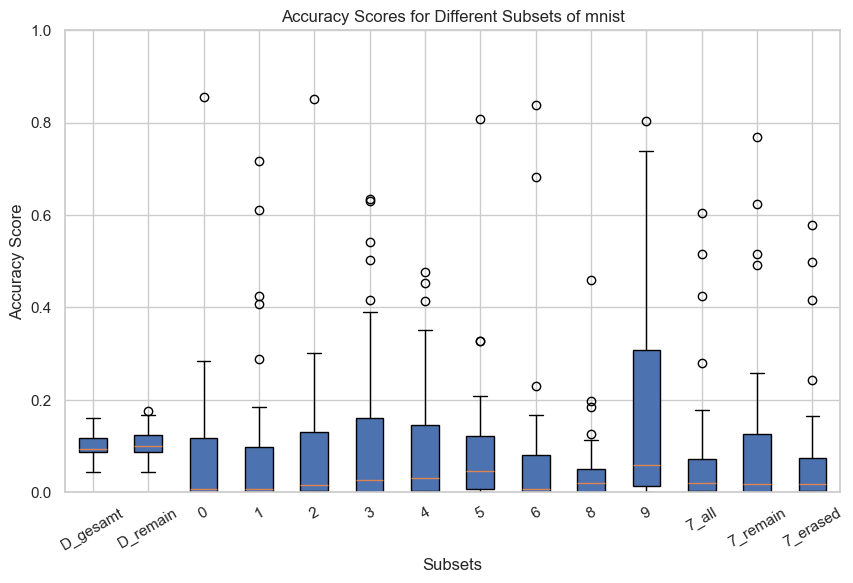

In [23]:
# Macht vllt ned so viel Sinn, fand i nur witzig
accs["untrained_ms"] = boxplotting_multimodel_eval(untrained_ms, dataset_name=USED_DATASET, evaluation="Accuracy", logs=True)

Starts evaluation for 'mnist'...


Average Accuracy for D_gesamt: 0.8710 - Standard Deviation for D_gesamt: 0.0012


Average Accuracy for D_remain: 0.8661 - Standard Deviation for D_remain: 0.0013


Average Accuracy for 0: 0.9473 - Standard Deviation for 0: 0.0018


Average Accuracy for 1: 0.9558 - Standard Deviation for 1: 0.0020


Average Accuracy for 2: 0.8368 - Standard Deviation for 2: 0.0026


Average Accuracy for 3: 0.8476 - Standard Deviation for 3: 0.0026


Average Accuracy for 4: 0.8762 - Standard Deviation for 4: 0.0057


Average Accuracy for 5: 0.7655 - Standard Deviation for 5: 0.0060


Average Accuracy for 6: 0.9265 - Standard Deviation for 6: 0.0017


Average Accuracy for 8: 0.8109 - Standard Deviation for 8: 0.0030


Average Accuracy for 9: 0.8422 - Standard Deviation for 9: 0.0047


Average Accuracy for 7_all: 0.8811 - Standard Deviation for 7_all: 0.0022


Average Accuracy for 7_remain: 0.6249 - Standard Deviation for 7_remain: 0.0116


Average Accuracy for 7_erased: 0.9214 - Standard Deviation for 7_erased: 0.0024
plotting...


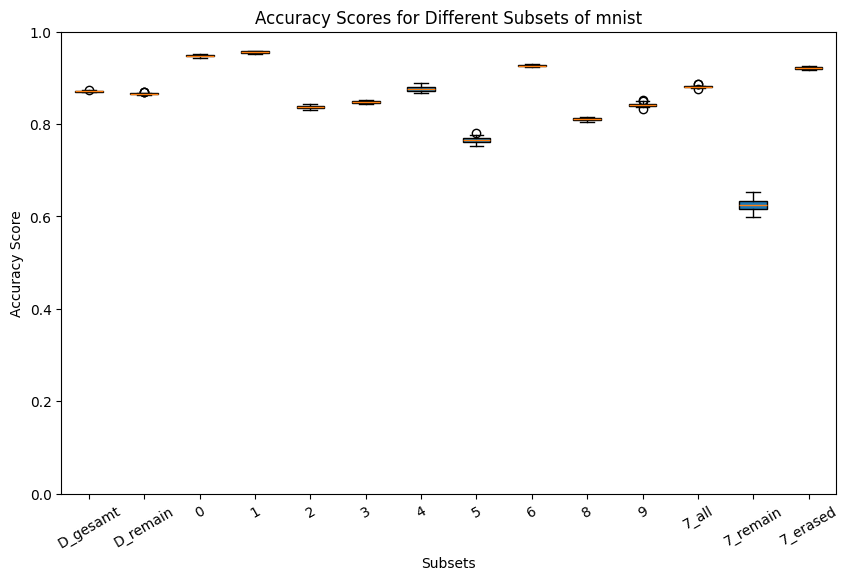

In [11]:
# can take like 80minutes
accs["trained_ms"] = boxplotting_multimodel_eval(trained_ms, dataset_name=USED_DATASET, evaluation="Accuracy", logs=True)

Starts evaluation for 'mnist'...


Average Accuracy for D_gesamt: 0.8435 - Standard Deviation for D_gesamt: 0.0020


Average Accuracy for D_remain: 0.8666 - Standard Deviation for D_remain: 0.0016


Average Accuracy for 0: 0.9470 - Standard Deviation for 0: 0.0028


Average Accuracy for 1: 0.9567 - Standard Deviation for 1: 0.0037


Average Accuracy for 2: 0.8195 - Standard Deviation for 2: 0.0047


Average Accuracy for 3: 0.8404 - Standard Deviation for 3: 0.0034


Average Accuracy for 4: 0.8664 - Standard Deviation for 4: 0.0090


Average Accuracy for 5: 0.7665 - Standard Deviation for 5: 0.0084


Average Accuracy for 6: 0.9257 - Standard Deviation for 6: 0.0036


Average Accuracy for 8: 0.8065 - Standard Deviation for 8: 0.0057


Average Accuracy for 9: 0.8536 - Standard Deviation for 9: 0.0053


Average Accuracy for 7_all: 0.6419 - Standard Deviation for 7_all: 0.0098


Average Accuracy for 7_remain: 0.8417 - Standard Deviation for 7_remain: 0.0040


Average Accuracy for 7_erased: 0.6105 - Standard Deviation for 7_erased: 0.0110
plotting...


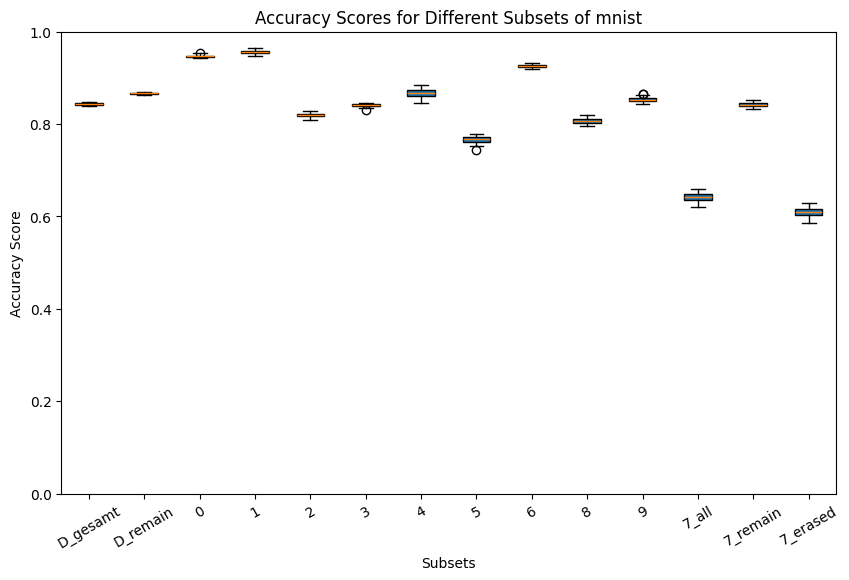

In [12]:
# can take like 80minutes
accs["exact_ms"] = boxplotting_multimodel_eval(exact_ms, dataset_name=USED_DATASET, evaluation="Accuracy", logs=True)

#### Losses

In [10]:
losses = {}

Starts evaluation for 'mnist'...


Average Loss for D_gesamt: 0.2881 - Standard Deviation for D_gesamt: 0.0009


Average Loss for D_remain: 0.2881 - Standard Deviation for D_remain: 0.0012


Average Loss for 0: 0.2877 - Standard Deviation for 0: 0.0083


Average Loss for 1: 0.2882 - Standard Deviation for 1: 0.0060


Average Loss for 2: 0.2886 - Standard Deviation for 2: 0.0079


Average Loss for 3: 0.2888 - Standard Deviation for 3: 0.0091


Average Loss for 4: 0.2875 - Standard Deviation for 4: 0.0058


Average Loss for 5: 0.2880 - Standard Deviation for 5: 0.0075


Average Loss for 6: 0.2900 - Standard Deviation for 6: 0.0086


Average Loss for 8: 0.2901 - Standard Deviation for 8: 0.0068


Average Loss for 9: 0.2850 - Standard Deviation for 9: 0.0080


Average Loss for 7_all: 0.2884 - Standard Deviation for 7_all: 0.0068


Average Loss for 7_remain: 0.2881 - Standard Deviation for 7_remain: 0.0076


Average Loss for 7_erased: 0.2884 - Standard Deviation for 7_erased: 0.0067
plotting...


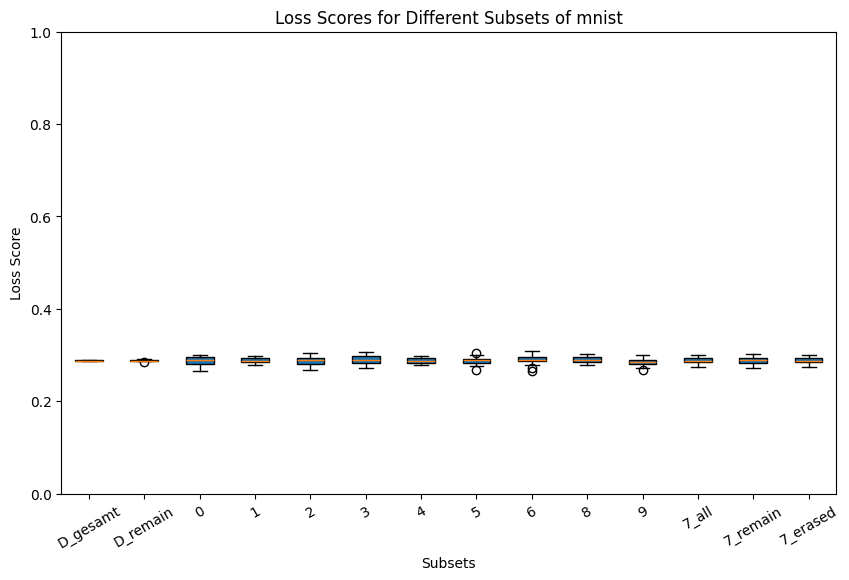

In [11]:
losses["untrained_ms"] = boxplotting_multimodel_eval(untrained_ms, dataset_name=USED_DATASET, evaluation="Loss", logs=True)

Starts evaluation for 'mnist'...


Average Loss for D_gesamt: 0.0740 - Standard Deviation for D_gesamt: 0.0004


Average Loss for D_remain: 0.0759 - Standard Deviation for D_remain: 0.0004


Average Loss for 0: 0.0399 - Standard Deviation for 0: 0.0007


Average Loss for 1: 0.0474 - Standard Deviation for 1: 0.0009


Average Loss for 2: 0.0746 - Standard Deviation for 2: 0.0008


Average Loss for 3: 0.0804 - Standard Deviation for 3: 0.0009


Average Loss for 4: 0.0787 - Standard Deviation for 4: 0.0013


Average Loss for 5: 0.1130 - Standard Deviation for 5: 0.0011


Average Loss for 6: 0.0490 - Standard Deviation for 6: 0.0008


Average Loss for 8: 0.0969 - Standard Deviation for 8: 0.0011


Average Loss for 9: 0.1000 - Standard Deviation for 9: 0.0014


Average Loss for 7_all: 0.0673 - Standard Deviation for 7_all: 0.0009


Average Loss for 7_remain: 0.1502 - Standard Deviation for 7_remain: 0.0025


Average Loss for 7_erased: 0.0543 - Standard Deviation for 7_erased: 0.0009
plotting...


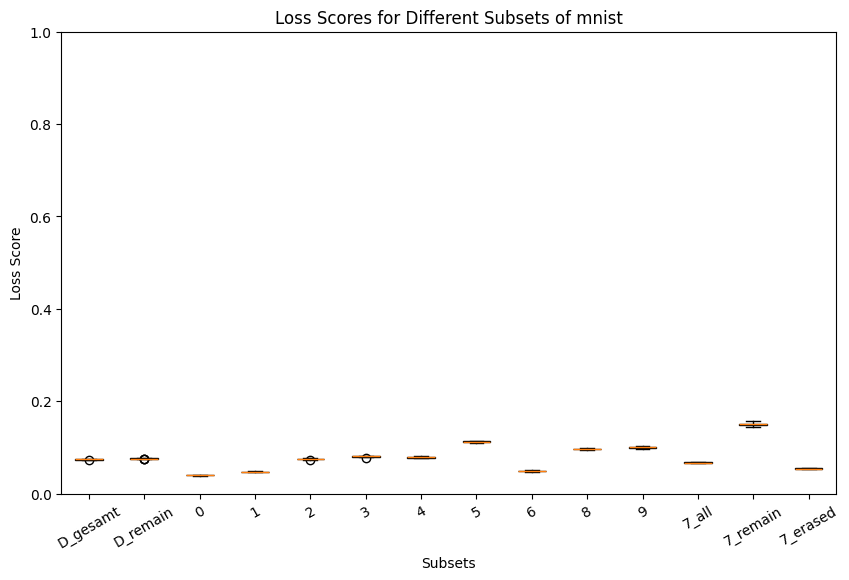

In [12]:
losses["trained_ms"] = boxplotting_multimodel_eval(trained_ms, dataset_name=USED_DATASET, evaluation="Loss", logs=True)

Starts evaluation for 'mnist'...


Average Loss for D_gesamt: 0.0810 - Standard Deviation for D_gesamt: 0.0005


Average Loss for D_remain: 0.0762 - Standard Deviation for D_remain: 0.0004


Average Loss for 0: 0.0397 - Standard Deviation for 0: 0.0010


Average Loss for 1: 0.0499 - Standard Deviation for 1: 0.0014


Average Loss for 2: 0.0789 - Standard Deviation for 2: 0.0012


Average Loss for 3: 0.0829 - Standard Deviation for 3: 0.0011


Average Loss for 4: 0.0828 - Standard Deviation for 4: 0.0016


Average Loss for 5: 0.1120 - Standard Deviation for 5: 0.0017


Average Loss for 6: 0.0498 - Standard Deviation for 6: 0.0012


Average Loss for 8: 0.0985 - Standard Deviation for 8: 0.0014


Average Loss for 9: 0.0969 - Standard Deviation for 9: 0.0015


Average Loss for 7_all: 0.1236 - Standard Deviation for 7_all: 0.0029


Average Loss for 7_remain: 0.0804 - Standard Deviation for 7_remain: 0.0009


Average Loss for 7_erased: 0.1304 - Standard Deviation for 7_erased: 0.0033
plotting...


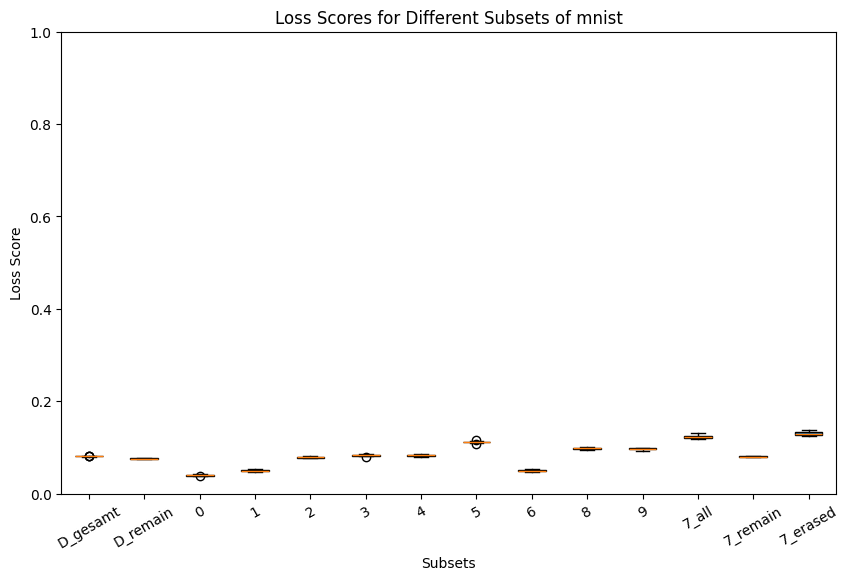

In [13]:
losses["exact_ms"] = boxplotting_multimodel_eval(exact_ms, dataset_name=USED_DATASET, evaluation="Loss", logs=True)

___

In [14]:
import os
import sys

# Add the parent directory to sys.path
sys.path.append(os.path.join('..', 'src'))

import torch
import torch.utils
import torch.utils.data
import torch.utils.data.dataloader
from mlp_dataclass import MNIST_CostumDataset


u_data = MNIST_CostumDataset(
    sample_mode="only_erased",
    train= False,
    test = True,
    classes=["7"],
    dataset_name = "mnist",
    download=True,
)
dl = torch.utils.data.DataLoader(
    dataset=u_data,
    batch_size=8,
    shuffle=False
)

class Noise(torch.nn.Module):
    def __init__(self, samples):
        super().__init__()
        self.noise = torch.nn.Parameter(samples, requires_grad = True)
        
    def forward(self):
        return self.noise
    

for x, y in dl:
    noise = Noise(x)
    break

In [15]:
noise.forward()[0].shape

torch.Size([784])